In [71]:
import random
import simpy
import numpy as np
import scipy.stats as st
import pandas as pd
import math

In [72]:
RANDOM_SEED = 42
TASK_MEAN = 24.0
# TASK_SIGMA = 2.0

INTERRUPTION_MEAN = 10.0
INTERRUPTION_SIGMA = 3.0

BREAK_MEAN = 6.0


random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [73]:
def time_per_task():
    return st.expon.rvs(size=1, scale=TASK_MEAN)[0]

def time_to_interrupt(enabled=1):
    if enabled:
        return st.expon.rvs(size=1, scale=INTERRUPTION_MEAN)[0]
    return 10000

def time_to_break(fixed=0):
    if fixed:
        return fixed
    return time_per_task()

def break_duration(fixed=0):
    if fixed:
        return fixed
    return st.expon.rvs(size=1, scale=BREAK_MEAN)[0]

def interruption_duration(enabled=1):
    if enabled:
        return st.expon.rvs(size=1, scale=INTERRUPTION_SIGMA)[0]
    return 0



Exception ignored in: <generator object Person.working at 0x2822b4270>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/tokenize.py", line 527, in _tokenize
    pseudomatch = _compile(PseudoToken).match(line, pos)
RuntimeError: generator ignored GeneratorExit


In [74]:



class Person:
    def __init__(self,env,state, b_time, b_duration, interr=True, verbose=False):
        # Simpy Config
        self.state = state
        self.env = env
        self.person = simpy.PreemptiveResource(env,capacity=1)

        #Variables
        self.completed_tasks = 0
        self.breaks = 0
        self.interrupts = 0
        self.task_duration_sum = 0
        self.break_duration_sum = 0
        self.interruption_duration_sum = 0

        # Metodología
        self.b_time, self.b_duration = b_time, b_duration
        self.interrupting_enabled = interr
        self.verbose = verbose
        
        #Procesos
        self.process_working = env.process(self.working())
        env.process(self.interrupting())
        self.process_break = env.process(self.take_break())

    def printv(self, s):
        if self.verbose:
            print(s)

    def working(self):
        while True:
            time = time_per_task()
            t_duration = time
            
            it = ""
            while time:    
                start = self.env.now
                try:
                    self.printv(f'Minuto {self.env.now} | {it}iniciando tarea {self.completed_tasks+1} | queda por trabajar {time} min')
                    self.state = 'W'

                    yield self.env.timeout(time)
                    time = 0
                    self.state = 'S'

                except simpy.Interrupt:
                    time = max(0, time + start - self.env.now)
                    
                    if self.state == 'I':
                        interruption_time = interruption_duration()
                        self.printv(f'Minuto {self.env.now} | trabajo interrumpido por {interruption_time} | quedando por completar unos {time} min de tarea')
                        
                        yield self.env.timeout(interruption_time)
                        self.printv(f'Minuto {self.env.now} | interrupción terminada')
                        self.interruption_duration_sum += interruption_time
                        self.interrupts += 1
                        self.state = 'W'
                        
                    elif self.state == 'D': 
                        break_time = break_duration(self.b_duration)
                        break_t = break_time
                        start_break = self.env.now
                        self.printv(f'Minuto {self.env.now} | descanso por {break_time} min | quedando por completar unos {time} min de tarea')

                        while break_time:
                            try:
                                yield self.env.timeout(break_time)
                                break_time = 0
                                #self.state = 'W'

                            except:
                                break_time = self.env.now - start_break
                                interruption_time = interruption_duration()
                                self.printv(f'Minuto {self.env.now} | descanso interrumpido por {interruption_time} min')
                                yield self.env.timeout(interruption_time)
                                self.printv(f'Minuto {self.env.now} | interrupción terminada')
                                self.interruption_duration_sum += interruption_time
                                self.interrupts += 1
                                # yield self.env.timeout(break_time)
                                self.state = 'D'

                        self.breaks += 1
                        self.break_duration_sum += break_t
                        self.printv(f'Minuto {self.env.now} | descanso completado en el minuto {self.env.now}' )
                                
                
                    # yield self.env.timeout(time)
                    # time = 0
                    # self.state = 'S'            

                it='re'    
                
            self.completed_tasks += 1
            self.task_duration_sum += t_duration
            self.printv(f'Minuto {self.env.now} | tarea numero {self.completed_tasks} completada')

    def take_break(self):
        dur = 0.0
        while True:
            time = time_to_break(self.b_time + dur)
            dur = self.b_duration
            yield self.env.timeout(time)
           
            with self.person.request(priority=1) as request:
                yield request
                    
                if self.state == 'W' and self.process_working.is_alive:
                    self.state = 'D'
                    self.process_working.interrupt()
                # elif self.state == 'I':
                #     print('no puedes descansar por interrupcion', self.env.now)
                

    def interrupting(self):
        while True:
            time = time_to_interrupt(self.interrupting_enabled)
            # print('solicitando proxima interrupcion en ', self.env.now, ' para dentro de :', time)
            yield self.env.timeout(time)
            
            with self.person.request(priority=0) as request:
                yield request
                # print('se obtuvo la interrupcion (el recurso) en el minuto', self.env.now)
                if (self.state == 'W' or self.state == 'D') and self.process_working.is_alive:
                    self.state = 'I'
                    self.process_working.interrupt()

                else:
                    self.printv(f'no se puede interrumpir en el minuto {self.env.now}')
            
    

## Preguntas
- Cual es la media de la cantidad de tareas resultas siguiendo cada estrategia?

- Comparar que estrategia de administración de tiempo es mas productiva?
  - 24-6
  - 12-3
  - Free

- ¿Cuál es la distribución de la cantidad de tareas completadas en la ventana de tiempo de 480 minutos? Esto te permitiría entender cuánto varía el rendimiento de la persona.

- ¿Cómo afecta la duración de los descansos a la cantidad de tareas completadas? Podrías comparar las simulaciones con diferentes duraciones de descanso para ver si hay alguna diferencia significativa.

- ¿Cómo afectan las interrupciones a la cantidad de tareas completadas? Similar a la pregunta anterior, podrías comparar las simulaciones con y sin interrupciones.

- ¿Cuál es la distribución del tiempo entre tareas completadas? Esto te permitiría entender cómo se distribuye el tiempo de trabajo de la persona.

- ¿Cómo se correlacionan el número de descansos y el número de tareas completadas? Esto podría ayudarte a entender si tomar más descansos lleva a completar más tareas.

In [75]:
import copy
random.seed(RANDOM_SEED)

def simulate(n, time, b_time=0, b_duration=0, interruptions=True, verbose=False, likelihood=False, MSE=10):
    df = pd.DataFrame({})

    i=0
    invalid = likelihood
    while invalid or i < n:
        env = simpy.Environment()
        person = Person(env,'S', b_time, b_duration, interruptions)
        env.run(until=time)
        env.event().succeed()
        env.event().succeed()
        env.event().succeed()
        # Data Collecting
        row = pd.DataFrame(
            {  
                "break_duration": [b_duration], 
                "break_timestamp": [b_time],
                "interruptions": [copy.copy(person.interrupts)],
                "completed_tasks": [copy.copy(person.completed_tasks)],
                "breaks": [copy.copy(person.breaks)],
                "working_time": [copy.copy(person.task_duration_sum)],
                "break_time": [copy.copy(person.break_duration_sum)],
                "interruption_time": [copy.copy(person.interruption_duration_sum)],
            }
        )
        df = pd.concat([df,row])

        # To verify stopping criteria
        if likelihood:
            est_std = df.std()
            # print(len(est_std[est_std/np.sqrt(i+1) < MSE]))
            invalid = len(est_std[est_std/np.sqrt(i+1) < MSE]) < 8
        

        # If the simulation verbosity is true the print the outcomes
        if verbose:
            print("Descanso: ",person.breaks)
            print("Tareas Completadas: ",person.completed_tasks)
            print("Duración Media de tareas: ",person.task_duration_sum/person.completed_tasks)
            print("Interrupciónes: ",person.interrupts)

        i+=1
        
        
    return df



## Extracting Data


In [78]:


df_rand = simulate(30, 480,12, 3,likelihood=True, MSE=5)
df_24_6 = simulate(30, 480, 24, 6, likelihood=True, MSE=5)
df_12_3 = simulate(30, 480, likelihood=True, MSE=5)
df_ni = simulate(30, 480, interruptions=False, likelihood=True, MSE=5)
# df_ni = simulate(20, 480, interruptions=False)

df = pd.concat([df_rand,df_24_6,df_12_3,df_ni])

df_12_3.head()

Exception ignored in: <generator object Person.working at 0x2822b6260>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/managers.py", line 2284, in _merge_blocks
    new_mgr_locs = np.concatenate([b.mgr_locs.as_array for b in blocks])
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object Person.working at 0x2822b58c0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/construction.py", line 605, in _homogenize
    if isinstance(val, (ABCSeries, Index)):
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object Person.working at 0x281f9ec70>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/construction.py", line 605, in _homogenize
    if isinstan

TypeError: cannot concatenate object of type '<class 'int'>'; only Series and DataFrame objs are valid

Exception ignored in: <generator object Person.working at 0x13fcdf060>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/tokenize.py", line 527, in _tokenize
    pseudomatch = _compile(PseudoToken).match(line, pos)
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object Person.working at 0x13fdc36f0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/tokenize.py", line 527, in _tokenize
    pseudomatch = _compile(PseudoToken).match(line, pos)
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object Person.working at 0x13fe28740>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/tokenize.py", line 527, in _tokenize
    pseudomatch = _compile(PseudoToken).match(line, pos)
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object 

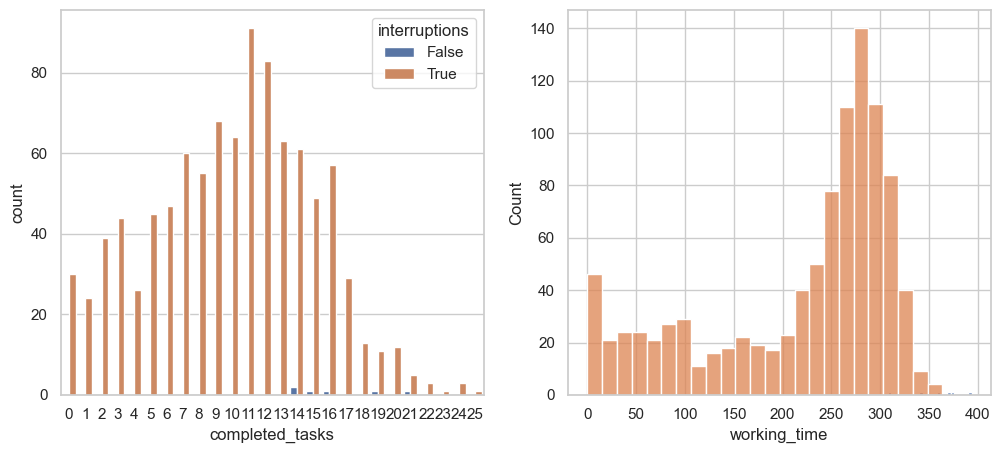

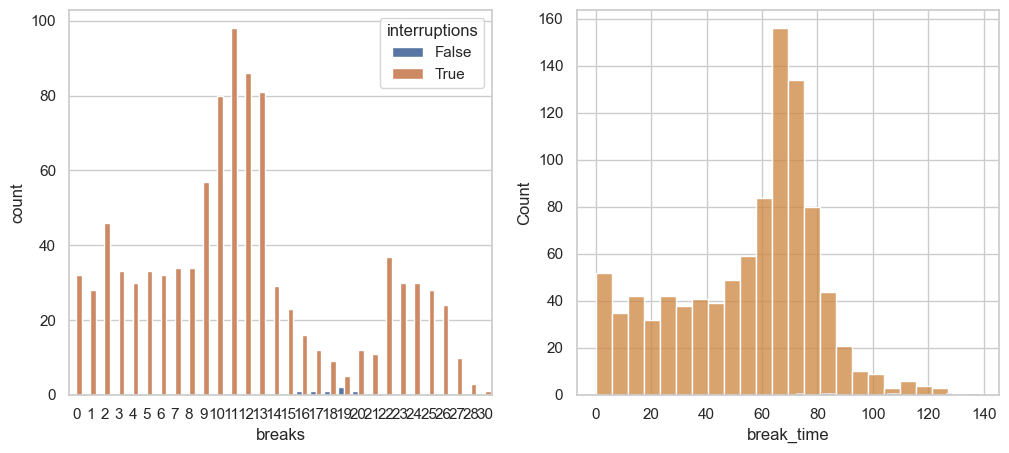

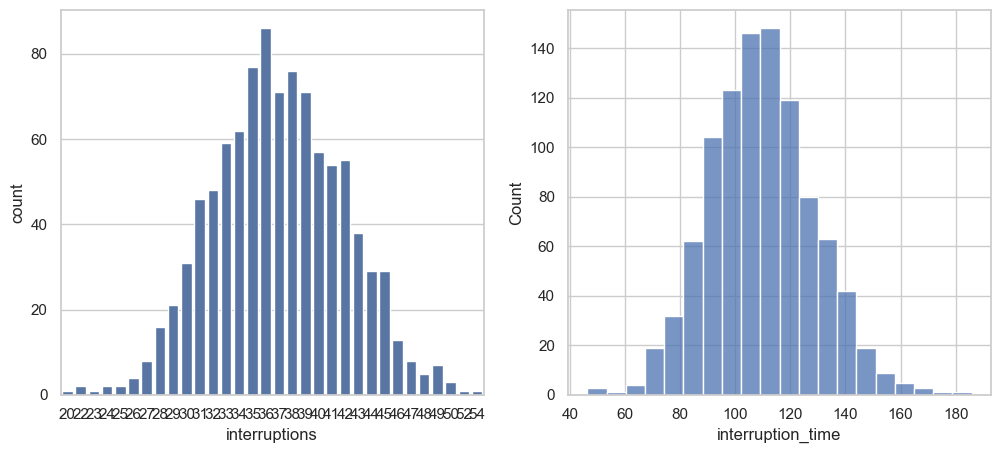

,index,break_duration,break_timestamp,interruptions,completed_tasks,breaks,working_time,break_time,interruption_time,time
0,0,3,12,41,11,27,269.534241,81.000000,95.409100,445.943341
1,0,3,12,37,17,24,277.450874,72.000000,118.976030,468.426904
2,0,3,12,32,17,25,278.897776,75.000000,113.781712,467.679487
3,0,3,12,37,14,23,275.089059,69.000000,89.318421,433.407480
4,0,3,12,35,6,23,276.568955,69.000000,126.588630,472.157584
...,...,...,...,...,...,...,...,...,...,...
985,0,0,0,0,14,17,360.601091,106.290371,0.000000,466.891462
986,0,0,0,0,19,19,368.651079,109.119265,0.000000,477.770344
987,0,0,0,0,16,16,340.565546,128.568344,0.000000,469.133890
988,0,0,0,0,14,20,393.678518,82.532760,0.000000,476.211279


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

df['time'] = df['working_time'] + df['break_time'] + df['interruption_time']

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.countplot(x = df['completed_tasks'], ax=ax[0], hue=df['interruptions'] > 0)
sns.histplot(data = df[df['interruptions'] == 0]['working_time'], bins=24, ax=ax[1])
sns.histplot(data = df[df['interruptions'] > 0]['working_time'], bins=24, ax=ax[1])
plt.show()

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.countplot(x = df['breaks'], ax=ax[0], hue=df['interruptions'] > 0)
sns.histplot(data = df[df['interruptions'] > 0]['break_time'], bins=24, ax=ax[1], color='peru')
sns.histplot(data = df[df['interruptions'] == 0]['break_time'], bins=24, ax=ax[1], alpha=0.5)
plt.show()

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.countplot(x = df[df['interruptions'] > 0]['interruptions'], ax=ax[0])
sns.histplot(data =df[df['interruptions'] > 0]['interruption_time'], bins=20, ax=ax[1])
plt.show()

# print(df['break_time'].max())
# print(df['break_time'].min())

# # print(df[df['break_time'] == df['break_time'].max()])
# # df[df['break_time'] == df['break_time'].max()]
df.reset_index()

Exception ignored in: <generator object Person.working at 0x292ec2500>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/transforms.py", line 198, in set_children
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object Person.working at 0x29f3bccf0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/transforms.py", line 198, in set_children
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))
RuntimeError: generator ignored GeneratorExit
Exception ignored in: <generator object Person.working at 0x29f3bd2a0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/transforms.py", line 198, in set_children
    self, lambda _, pop=child._parents.po

se termino el proceso


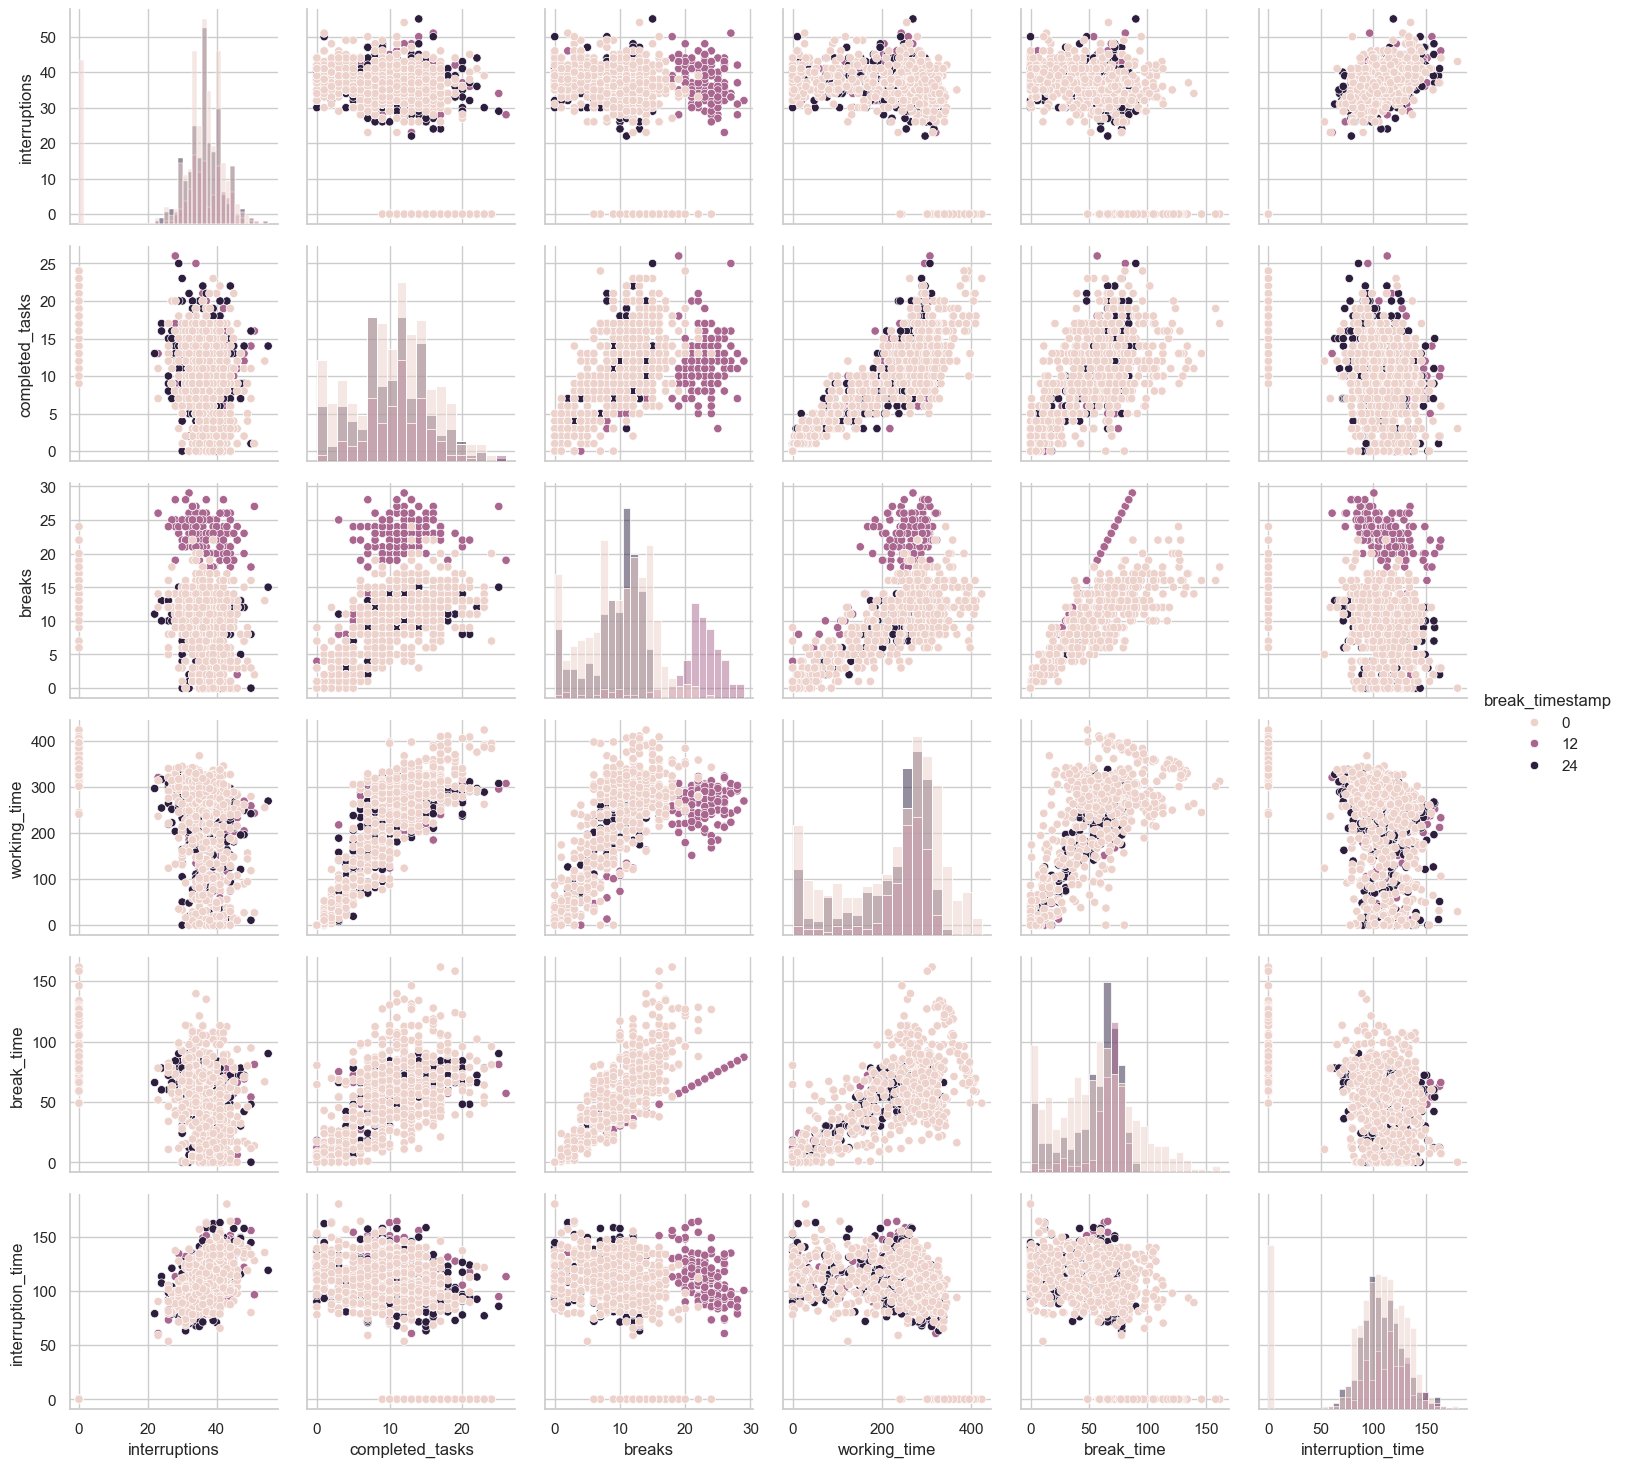

In [147]:

g = sns.PairGrid(df.iloc[:,1:-1], hue='break_timestamp')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

# df.iloc[:,1:]

In [116]:
import pingouin

pingouin.kruskal(data=pd.concat([df_12_3, df_24_6, df_rand]), dv='working_time', between='break_timestamp')


,Source,ddof1,H,p-unc
Kruskal,break_timestamp,2,0.316709,0.853547
